# 01 - Khám phá dữ liệu HR Analytics: Job Change

Mục tiêu notebook:

- Đọc và quan sát sơ bộ dữ liệu.
- Trả lời một số **câu hỏi phân tích dữ liệu**, ví dụ:
  - Ứng viên thuộc ngành nào có xu hướng đổi việc nhiều hơn?
  - Kinh nghiệm ít/nhiều có ảnh hưởng đến việc muốn đổi việc?
  - Giới tính, trình độ học vấn, loại trường, loại công ty có khác biệt gì về `target`?
- Vẽ các biểu đồ đơn giản bằng **Matplotlib + Seaborn**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

# ====== Setup đường dẫn project ======
BASE_DIR = os.path.abspath("..")
sys.path.append(BASE_DIR)

DATA_PATH = os.path.join(BASE_DIR, "data", "raw", "aug_train.csv")

from src.data_processing import (
    load_dataset,
    get_column_indices,
)
from src.visualization import (
    plot_histogram,
    plot_bar_counts,
    plot_pie,
)

header, data = load_dataset(DATA_PATH)

print("Số dòng:", data.shape[0])
print("Số cột:", data.shape[1])
print("Tên cột:", header)


Số dòng: 2129
Số cột: 13
Tên cột: ['enrollee_id', 'city', 'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours']


## Cấu trúc dữ liệu

- **Đầu vào**: Các thông tin cơ bản của ứng viên:
  - `city`, `city_development_index`, `gender`, `relevent_experience`,
    `enrolled_university`, `education_level`, `major_discipline`,
    `experience`, `company_size`, `company_type`, `last_new_job`, `training_hours`, ...
- **Đầu ra (`target`)**:
  - `0` = Không muốn thay đổi công việc
  - `1` = Có ý định thay đổi công việc

In [9]:
# Lấy index các cột hay dùng
city_idx = header.index("city")
cdi_idx = header.index("city_development_index")
gender_idx = header.index("gender")
re_idx = header.index("relevent_experience")
edu_idx = header.index("education_level")
major_idx = header.index("major_discipline")
exp_idx = header.index("experience")
company_type_idx = header.index("company_type")
last_new_job_idx = header.index("last_new_job")
training_hours_idx = header.index("training_hours")
target_idx = header.index("target")

target_col = data[:, target_idx]

print("Giá trị target khác nhau:", np.unique(target_col, return_counts=True))


ValueError: 'target' is not in list

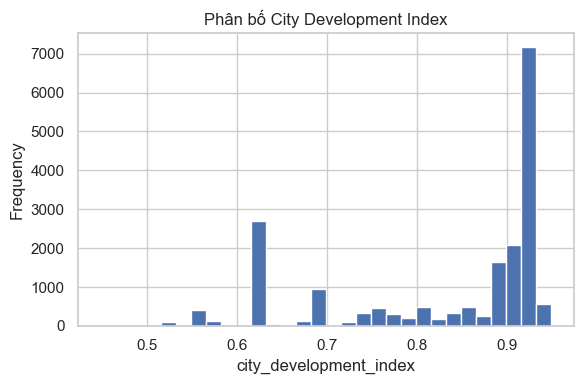

In [ ]:
cdi_col = data[:, cdi_idx].astype(float)

plot_histogram(
    cdi_col,
    title="Phân bố City Development Index",
    xlabel="city_development_index",
)

## Q2: Tỷ lệ giới tính trong dataset?

Xem xem:

- Dataset có mất cân bằng giới tính không?
- Điều này có khả năng gây bias khi phân tích/huấn luyện model không?


Các giá trị gender: (array(['', 'Female', 'Male', 'Other'], dtype='<U23'), array([ 4508,  1238, 13221,   191]))


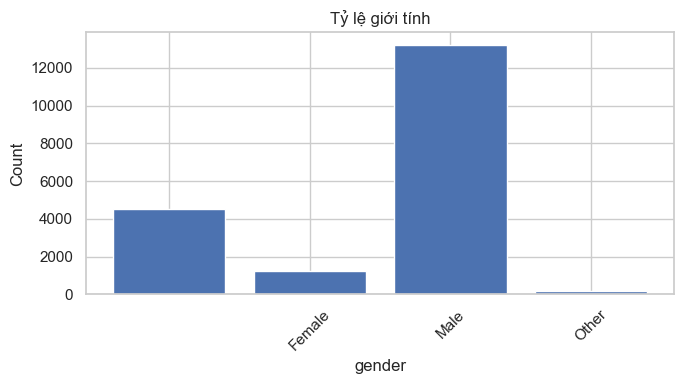

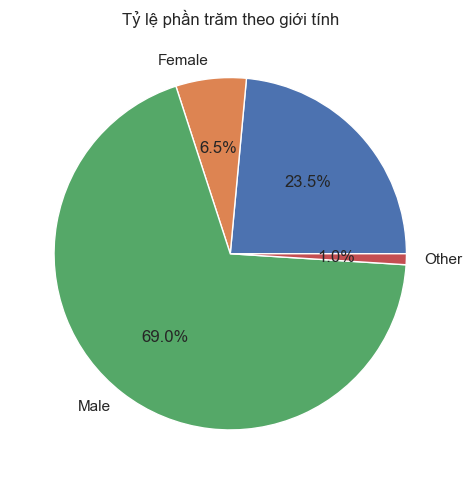

In [ ]:
gender_col = data[:, gender_idx]
print("Các giá trị gender:", np.unique(gender_col, return_counts=True))

plot_bar_counts(
    gender_col,
    title="Tỷ lệ giới tính",
    xlabel="gender",
)

plot_pie(
    gender_col,
    title="Tỷ lệ phần trăm theo giới tính",
)


## Q3: Kinh nghiệm liên quan (`relevent_experience`) có phổ biến không?

- Có bao nhiêu ứng viên đã có kinh nghiệm liên quan?
- Nhóm nào có tỷ lệ muốn đổi việc cao hơn?

Giá trị relevent_experience: (array(['Has relevent experience', 'No relevent experience'], dtype='<U23'), array([13792,  5366]))


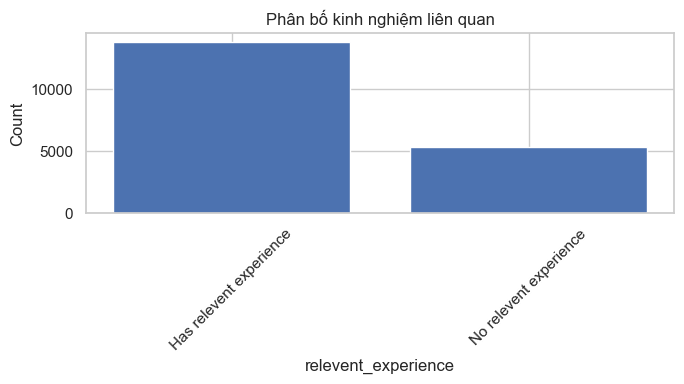

relevent_experience = Has relevent experience -> tỷ lệ muốn đổi việc: 0.21
relevent_experience = No relevent experience -> tỷ lệ muốn đổi việc: 0.34


In [ ]:
re_col = data[:, re_idx]

print("Giá trị relevent_experience:", np.unique(re_col, return_counts=True))

plot_bar_counts(
    re_col,
    title="Phân bố kinh nghiệm liên quan",
    xlabel="relevent_experience",
)

# Tỷ lệ target=1 theo relevent_experience
unique_re = np.unique(re_col)
for v in unique_re:
    mask = re_col == v
    sub_target = target_col[mask]
    if sub_target.size == 0:
        continue
    ratio = np.mean(sub_target == "1.0")
    print("relevent_experience = %s -> tỷ lệ muốn đổi việc: %.2f" % (v, ratio))


## Q4: Ngành học/chuyên môn (`major_discipline`) nào có nhiều người muốn đổi việc nhất?

Xem:

- Các ngành STEM, Business, Arts, ... có khác biệt về `target` không?


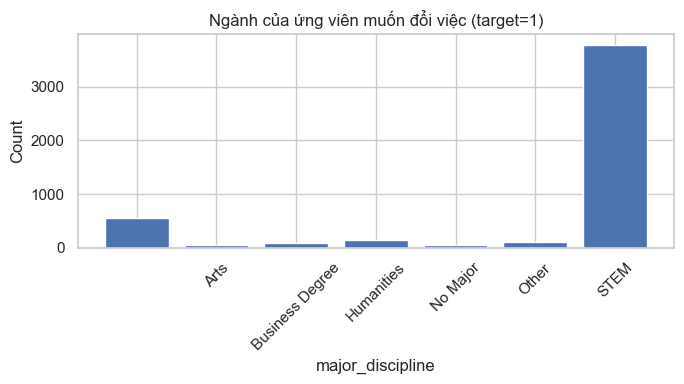

Tỷ lệ muốn đổi việc theo ngành:
: 0.20
Arts: 0.21
Business Degree: 0.26
Humanities: 0.21
No Major: 0.25
Other: 0.27
STEM: 0.26


In [ ]:
major_col = data[:, major_idx]

target_1_mask = target_col == "1.0"
major_target_1 = major_col[target_1_mask]

plot_bar_counts(
    major_target_1,
    title="Ngành của ứng viên muốn đổi việc (target=1)",
    xlabel="major_discipline",
)

# Tỷ lệ target=1 theo từng ngành
unique_major = np.unique(major_col)
print("Tỷ lệ muốn đổi việc theo ngành:")
for v in unique_major:
    mask = major_col == v
    sub_target = target_col[mask]
    if sub_target.size == 0:
        continue
    ratio = np.mean(sub_target == "1.0")
    print("%s: %.2f" % (v, ratio))


## Q5: Kinh nghiệm làm việc (`experience`) ảnh hưởng thế nào tới xu hướng đổi việc?

Giả thuyết:

- Ứng viên ít kinh nghiệm (0–2 năm) có thể thay đổi việc nhiều hơn (chưa ổn định).
- Ứng viên > 10 năm có thể ít đổi việc hơn (đã ổn định, vị trí cao).

Ta sẽ tính tỷ lệ `target=1` theo từng mức `experience`.


In [ ]:
# Cột experience (string)
exp_col = data[:, exp_idx]
target_col = data[:, target_idx]

# Các giá trị xuất hiện trong dữ liệu
unique_raw = np.unique(exp_col)

# Thứ tự kinh nghiệm mong muốn
order = ["<1", "1", "2", "3", "4", "5", "6", "7", "8", "9",
         "10", "11", "12", "13", "14", "15", "16", "17",
         "18", "19", "20", ">20"]

# Lọc theo thứ tự này, chỉ giữ những giá trị thật sự có trong dữ liệu
unique_sorted = [v for v in order if v in unique_raw]

print("Thứ tự experience:", unique_sorted)

# Tính tỷ lệ target=1 theo từng mức kinh nghiệm (theo thứ tự đã sort)
ratios = []

for v in unique_sorted:
    mask = (exp_col == v)
    sub_target = target_col[mask]
    if sub_target.size == 0:
        ratio = 0.0
    else:
        ratio = np.mean(sub_target == "1.0")
    ratios.append(ratio)

print("Kinh nghiệm\tTỷ lệ muốn đổi việc")
for v, r in zip(unique_sorted, ratios):
    print("%s\t\t%.2f" % (v, r))

Thứ tự experience: ['<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20']
Kinh nghiệm	Tỷ lệ muốn đổi việc
<1		0.45
1		0.42
2		0.33
3		0.35
4		0.33
5		0.29
6		0.28
7		0.29
8		0.24
9		0.22
10		0.21
11		0.23
12		0.19
13		0.19
14		0.18
15		0.17
16		0.14
17		0.17
18		0.15
19		0.17
20		0.22
>20		0.15
